# Heart Failure Prediction


In [49]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier

## Information About Each Column

- Attribute Information
- Age: age of the patient [years]
- Sex: sex of the patient [M: Male, F: Female]
- ChestPainType: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
- RestingBP: resting blood pressure [mm Hg]
- Cholesterol: serum cholesterol [mm/dl]
- FastingBS: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
- RestingECG: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
- MaxHR: maximum heart rate achieved [Numeric value between 60 and 202]
- ExerciseAngina: exercise-induced angina [Y: Yes, N: No]
- Oldpeak: oldpeak = ST [Numeric value measured in depression]
- ST_Slope: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
- HeartDisease: output class [1: heart disease, 0: Normal]


In [50]:
df = pd.read_csv("heart.csv")

df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [52]:
df["Sex"] = df["Sex"].map({"M": 1, "F": 0})
df["ExerciseAngina"] = df["ExerciseAngina"].map({"Y": 1, "N": 0})

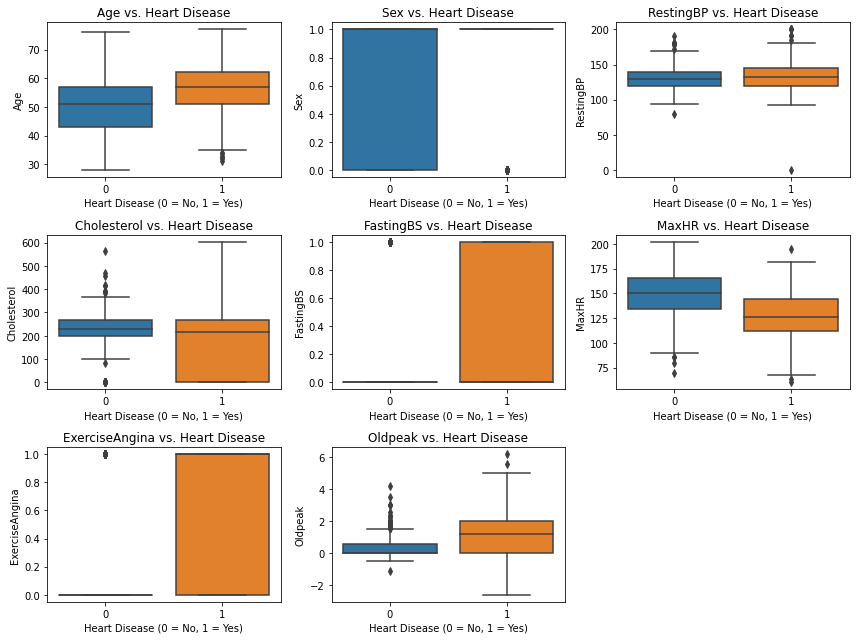

In [53]:
numerical_features = df.select_dtypes(include=["int64", "float64"]).columns
numerical_features = numerical_features.drop("HeartDisease")

rows, cols = 3, 3
fig, axes = plt.subplots(rows, cols, figsize=(12, 9))  # Adjust size as needed

# Flatten axes array for easy iteration
axes = axes.flatten()

# Loop through each feature and create a boxplot
for i, column in enumerate(numerical_features):
    sns.boxplot(x=df["HeartDisease"], y=df[column], ax=axes[i])
    axes[i].set_title(f"{column} vs. Heart Disease")
    axes[i].set_xlabel("Heart Disease (0 = No, 1 = Yes)")
    axes[i].set_ylabel(column)

# Hide any extra subplots (in case there are fewer than 9 features)
for i in range(len(numerical_features), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

In [54]:
X = df[["Age", "RestingBP", "Cholesterol"]]
y = df["HeartDisease"]

x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = LogisticRegression()
model.fit(x_train, y_train)

y_pred = model.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")
print(classification_report(y_test, y_pred))

Model Accuracy: 0.63
              precision    recall  f1-score   support

           0       0.56      0.56      0.56        77
           1       0.68      0.68      0.68       107

    accuracy                           0.63       184
   macro avg       0.62      0.62      0.62       184
weighted avg       0.63      0.63      0.63       184



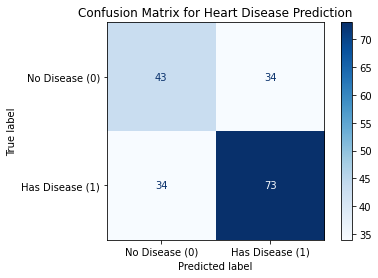

In [55]:
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=["No Disease (0)", "Has Disease (1)"]
)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix for Heart Disease Prediction")
plt.show()

### Feature Engineering to Improve Results

One of the things that I think can help improve the model accuracy is using the chest pain type. I am going to use ChatGPT definitions for each type of chest pain then classify them based on the meaning they give me:

1. Least Worrying: NAP
2. Moderate Risk: ATA
3. High Risk: TA
4. Most Dangerous: ASY

In [56]:
df['ChestPainType'] = df['ChestPainType'].map({'TA': 2, 'ATA': 1, 'NAP': 0, 'ASY': 3})

## Working With K-Nearest Neighbors (KNN)


### Step #1: Find Best K

Our objective is to determine how well KNN performs in predicting heart disease by testing different values of k (the number of neighbors considered in classification).
We then analyze which k-value gives the best accuracy and plot the results.


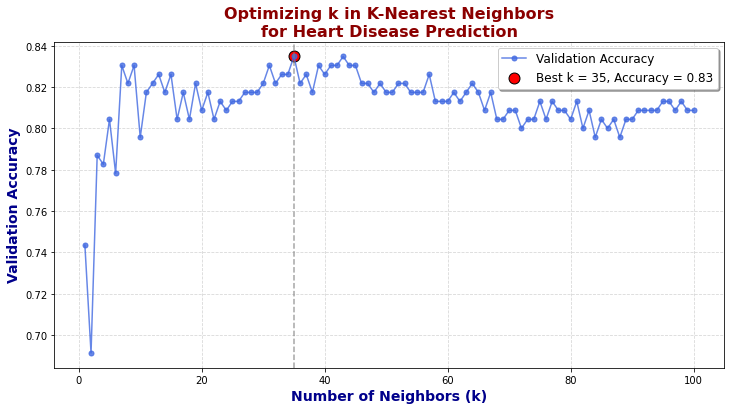

In [57]:
train_data, validation_data, train_labels, validation_labels = train_test_split(
    df[["RestingBP", "Age", "MaxHR", "Cholesterol", "Oldpeak", "ChestPainType"]],
    df["HeartDisease"],
    random_state=42,
)

scaler = StandardScaler()
train_data = scaler.fit_transform(train_data)
validation_data = scaler.transform(validation_data)

accuracies = []
for i in range(1, 101):
    classifier = KNeighborsClassifier(n_neighbors=i)
    classifier.fit(train_data, train_labels)
    accuracies.append(classifier.score(validation_data, validation_labels))

k_list = range(1, 101)

plt.figure(figsize=(12, 6))


plt.plot(
    k_list,
    accuracies,
    linestyle="-",
    marker="o",
    markersize=5,
    color="royalblue",
    alpha=0.8,
    label="Validation Accuracy",
)

best_k = k_list[accuracies.index(max(accuracies))]  # Let's us find k with max accuracy
best_acc = max(accuracies)

plt.scatter(
    best_k,
    best_acc,
    color="red",
    s=120,
    edgecolors="black",
    label=f"Best k = {best_k}, Accuracy = {best_acc:.2f}",
)

plt.xlabel("Number of Neighbors (k)", fontsize=14, fontweight="bold", color="darkblue")
plt.ylabel("Validation Accuracy", fontsize=14, fontweight="bold", color="darkblue")
plt.title(
    "Optimizing k in K-Nearest Neighbors\nfor Heart Disease Prediction",
    fontsize=16,
    fontweight="bold",
    color="darkred",
)

plt.axvline(best_k, color="gray", linestyle="dashed", alpha=0.7)
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(fontsize=12, loc="best", frameon=True, shadow=True)
plt.show()

### Step #2: Evaluating the Final Model
With our best K, we can now evaluate the model with this best K


In [58]:
best_knn = KNeighborsClassifier(n_neighbors=best_k)
best_knn.fit(train_data, train_labels)

final_pred = best_knn.predict(validation_data)

scoring_accuracy = accuracy_score(validation_labels, final_pred)
print(f"Final Model Accuracy: {scoring_accuracy:.2f}")

print("\nClassification Report:")
print(classification_report(validation_labels, final_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(validation_labels, final_pred))



Final Model Accuracy: 0.83

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.88      0.82        98
           1       0.90      0.80      0.85       132

    accuracy                           0.83       230
   macro avg       0.83      0.84      0.83       230
weighted avg       0.84      0.83      0.84       230


Confusion Matrix:
[[ 86  12]
 [ 26 106]]
